## 1. Load libraries, and set notebooks path once for all

In [1]:
import os, pyreadstat, re
from bs4 import BeautifulSoup

os.getcwd() # Make sure to be in the 'notebooks' folder

'C:\\Users\\pfaha\\PROJECTS\\brfss-diabetes-surveys\\brfss_diabetes_surveys_etl\\notebooks'

## 2. Load data, and its variables' description

In [2]:
df, _ = pyreadstat.read_xport('../data/LLCP2024.xpt', encoding='windows-1252') 

In [3]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_LCSCTSN,_LCSPSTF,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK3,_RFDRHV9,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,2.0,02282024,02,28,2024,1100.0,2024000001,2.024000e+09,1.0,...,NaN,9.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
1,1.0,2.0,02212024,02,21,2024,1100.0,2024000002,2.024000e+09,1.0,...,4.0,9.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0
2,1.0,2.0,02212024,02,21,2024,1100.0,2024000003,2.024000e+09,1.0,...,4.0,2.0,1.0,100.0,2.0,1400.0,1.0,NaN,NaN,2.0
3,1.0,2.0,02282024,02,28,2024,1100.0,2024000004,2.024000e+09,1.0,...,NaN,9.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0
4,1.0,2.0,02212024,02,21,2024,1100.0,2024000005,2.024000e+09,1.0,...,3.0,9.0,2.0,0.0,1.0,0.0,1.0,NaN,NaN,2.0


In [4]:
df.shape

(457670, 301)

For detailed information on variable definitions and BRFSS 2024 data collection methodology, consult the [official 2024 BRFSS documentation](https://www.cdc.gov/brfss/annual_data/annual_2024.html).

The dataset contains post-processed responses from standardized questionnaires administered identically across all respondents. The BRFSS applied methodology ensures the final data is representative of each U.S. part considered.

In [5]:
# Parse variables' description HTML text 
def clean_html_text(text):
    """Fix BRFSS codebook formatting"""
    # A quick fix on some exact non-breaking spaces & weird chars
    text = text.replace('\xa0', ' ').replace('�', '')
    # A normalization of only the needed section headers
    text = re.sub(pattern=r'Section\s+Name:\s*', repl='Section Name: ', string=text, flags=re.IGNORECASE)
    text = re.sub(pattern=r'SAS\s+Variable\s+Name:\s*', repl='SAS Variable Name: ', string=text, flags=re.IGNORECASE)
    return text.strip()
def extract_html_text(html_path):
    with open(html_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')
        for script in soup(["script", "style"]): 
            script.decompose()
        text = soup.get_text(separator=' ')
        return clean_html_text(text)

text = extract_html_text('../docs/USCODE24_LLCP_082125.HTML')
text[:300]

'LLCP 2024: Codebook Report \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n             LLCP 2024 Codebook Report \n \n \n   \n \n \n Overall version data \n \n \n weighted with _LLCPWT \n \n \n Behavioral Risk Factor Surveillance System \n \n \n August 21, 2025 \n \n \n  \n  \n  \n  \n  \n  \n  \n \n \n \n \n \n \n \n \n \n \n \n \n   \n \n \n   '

## 3. Perform some preprocessing

In [6]:
df1 = df.copy()

### 3.1. BRFSS Calculated Variables

In [7]:
# Remove any BRFSS Calculated Variables (Section Name: Calculated Variables), except '_SEX', '_AGE80'
def extract_computed_vars(text):
    """Extract SAS variables from 'Calculated Variables' sections"""
    pattern = r'Section Name: Calculated Variables.*?SAS Variable Name:\s*(_?[A-Z0-9]+)'
    matches = re.findall(pattern, text, re.DOTALL | re.IGNORECASE)
    return list(set(matches))

computed_vars = set(extract_computed_vars(text))
computed_vars = [x for x in computed_vars.intersection(df1.columns) if x not in ['_SEX', '_AGE80']]
assert len(computed_vars) <= 66-2, 'Wrong pattern used !!!' # Should be <= 66-2, because we know the exact number

print(f"Removing {len(computed_vars)} calculated variables by BRFSS...")
df1 = df1.drop(columns=computed_vars)

Removing 60 calculated variables by BRFSS...


### 3.2. BRFSS Record Identification Variables

In [8]:
# Remove any BRFSS Record Identification Variables except '_STATE'
def extract_record_vars(text):
    """Extract SAS variables from 'Record Identification' sections"""
    pattern = r'Section Name: Record Identification.*?SAS Variable Name:\s*(_?[A-Z0-9]+)'
    matches = re.findall(pattern, text, re.DOTALL | re.IGNORECASE)
    return list(set(matches))

record_vars = set(extract_record_vars(text))
record_vars = [x for x in record_vars.intersection(df1.columns) if x != '_STATE']
assert len(record_vars) <= 9-1 # Should be 9-1, because we know the exact number

print(f"Removing {len(record_vars)} record identification variables by BRFSS...")
df1 = df1.drop(columns=record_vars)

Removing 8 record identification variables by BRFSS...


### 3.3. Highly Imbalanced Variables

In [9]:
# Detect any column with an extremely dominant category/value
DOMINANCE_THESHOLD = 0.995
cols_max_prop = {col: df1[col].value_counts(normalize=True, dropna=False).iloc[0] for col in df1.columns}
cols_to_remove = [col for col in cols_max_prop.keys() if cols_max_prop[col] >= DOMINANCE_THESHOLD]

print(f"Removing {len(cols_to_remove)} columns with an extremely dominant value (at least {DOMINANCE_THESHOLD:.1%} of its rows)...")
df1 = df1.drop(columns=cols_to_remove)

Removing 7 columns with an extremely dominant value (at least 99.5% of its rows)...


### 3.4. Diabetes Variables

In [10]:
# Make sure the target diabetes column is still present ('DIABETE4'), and remove any others similar to it
diabetes_cols = df1.filter(regex='.*DIAB.*', axis=1).columns.tolist()
cols_to_remove = [col for col in diabetes_cols if col != 'DIABETE4']

print(f"Removing {len(cols_to_remove)} unwanted 'DIAB' columns...")
df1 = df1.drop(columns=cols_to_remove)

Removing 6 unwanted 'DIAB' columns...


In [11]:
# Reorganise 'DIABETE4' column's labels: keep only good and non-ambiguous labels such as 1.0, 3.0 and 4.0
# Feel free to consult its report USCODE_LLCP_082125.HTML to understand the meaning of those kept values
# 1.0, 2.0: diabetes -> 2
# 4.0: prediabetes -> 1
# 3.0: no diabetes/prediabetes -> 0

df1['DIABETE4'] = df1['DIABETE4'].replace({1.0: 2, 4.0: 1, 3.0: 0})
df1 = df1[df1['DIABETE4'].isin([0, 1, 2])]
df1['DIABETE4'] = df1['DIABETE4'].astype(int)

df1['DIABETE4'].value_counts(dropna=False)

DIABETE4
0    376125
2     69204
1     11307
Name: count, dtype: int64

### 3.5. Categorical Variables

In [12]:
df1.nunique().describe() # At least 75% of columns can be considered as categorical ones

count       220.000000
mean       1375.809091
std       17317.029724
min           1.000000
25%           4.000000
50%           4.000000
75%           7.250000
max      255871.000000
dtype: float64

<Axes: title={'center': 'Unique Values Per Column (Sorted, Log Scale)'}>

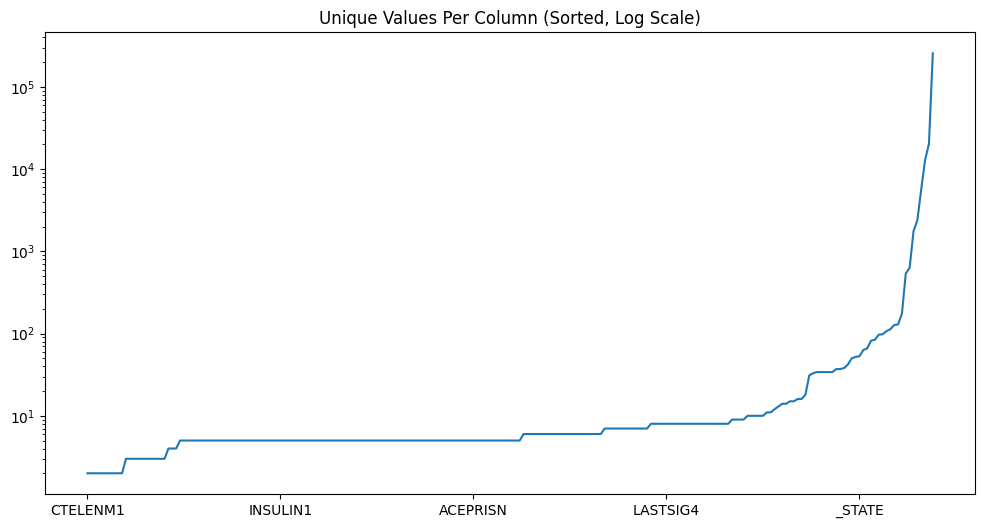

In [13]:
df1.nunique(dropna=False).sort_values().plot(logy=True, figsize=(12,6), title='Unique Values Per Column (Sorted, Log Scale)')

In [14]:
# Any variable with fewer than 100 values is converted to categorical
CAT_THRESHOLD = 100
cat_cols = [col for col in df1.columns if df1[col].nunique() <= CAT_THRESHOLD]

print(f"Making sure that {len(cat_cols)} variables with <{CAT_THRESHOLD} unique values are encoded as categorical...")
df1[cat_cols] = df1[cat_cols].astype('category')

Making sure that 207 variables with <100 unique values are encoded as categorical...


### 3.6. Missing Values

In [15]:
(df1.isnull().sum()/len(df1)).describe() # Only less than 25% of the data has non-missing values

count    220.000000
mean       0.540454
std        0.406897
min        0.000000
25%        0.032654
50%        0.638137
75%        0.948389
max        0.994258
dtype: float64

<Axes: title={'center': 'Missing Values Proportion Per Column'}>

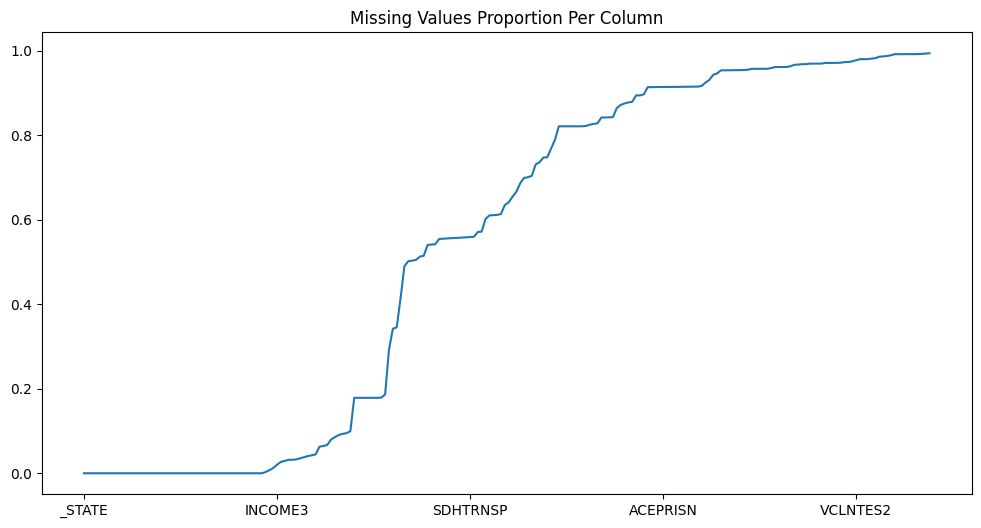

In [16]:
(df1.isnull().sum()/len(df1)).sort_values().plot(figsize=(12,6), title='Missing Values Proportion Per Column')

In [17]:
# Any variable with a proportion of missing values proportion more 3% is excluded from any further study
NA_THRESHOLD = 0.03
cols_na_prop = {col: df1[col].isnull().sum()/len(df1) for col in df1.columns}
cols_to_remove = [col for col in cols_na_prop.keys() if cols_na_prop[col] >= NA_THRESHOLD]

print(f"Removing {len(cols_to_remove)} columns having at least {NA_THRESHOLD:.0%} of NA values...")
df1 = df1.drop(columns=cols_to_remove)

Removing 167 columns having at least 3% of NA values...


### 3.6. Duplicated Rows

In [18]:
# Remove any eventual redundant row
print(f"Rows before deduplication: {len(df1)}")
df1 = df1.drop_duplicates()
print(f"Rows after deduplication: {len(df1)}")

Rows before deduplication: 456636
Rows after deduplication: 456603


In [19]:
df1.shape

(456603, 53)

In [20]:
df1.head()

,_STATE,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,PRIMINS2,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,...,_MRACE1,_HISPANC,_RACE,_RACEG21,_RACEGR3,_RACEPRV,_SEX,_AGE80,_AGE_G,DROCDY4_
0,1.0,2.0,3.0,2.0,88.0,3.0,2.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,78.0,6.0,0.0
1,1.0,1.0,1.0,88.0,88.0,3.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,80.0,6.0,0.0
2,1.0,1.0,2.0,30.0,88.0,1.0,3.0,1.0,4.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,59.0,5.0,100.0
3,1.0,1.0,1.0,88.0,88.0,3.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,80.0,6.0,0.0
4,1.0,1.0,3.0,88.0,88.0,5.0,1.0,2.0,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,47.0,4.0,0.0


**We will consider 52 characteristics for 456,603 individuals to explain their state of health regarding diabetes and prediabetes.**